# FibreSight - Overview

This notebook is divided into two main sections:

1. Characterising Fibres with an Alignment Score: The first part demonstrates how to characterise fibres using `fibsight` by computing an alignment score, defined as $1-\mathbb{V}_c[\cdot]$, where $\mathbb{V}_c[\cdot]$ is the circular variance. The image is first partitioned into geometrically-homogeneous regions. In each region, the alignment score is then computed.

2. Customising the Pipeline: The second part illustrates how to modify the pipeline's methods to accommodate various types of images.


In [1]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff

import fibsight
import fibsight.pipeline
from fibsight import ThresholdingMethod
from fibsight.custom.config_template import GraphConfig

print(f"Environment details: Python version {sys.version.split()[0]}, fibsight version {fibsight.__version__}")

Environment details: Python version 3.10.18, fibsight version 0.1.dev10+gabcd7ac.d20250605


## Table of Contents

- [FibreDescriptor Class Overview](#fibredescriptor-class-overview)
  - [Purpose](#purpose)
  - [Attributes](#attributes)
  - [Key Methods](#key-methods)
  - [Usage Example](#usage-example)
  - [Notes](#notes)
- [Defining Custom Methods](#custom-classes)
  - [Custom Thresholding Method](#custom-thresholding-method)
  - [Custom Partition Method](#custom-partition)
  - [Custom Skeletonisation Method](#custom-skeletonisation-method)
  - [Custom Statistics](#custom-statistics)
- [Regularisation](#regularisation)


## FibreDescriptor Class

The `FibreDescriptor` class is the backbone of the FibreSight image processing pipeline. It is designed to process images of fibres, enhance them, and create graph representations based on the processed images. The class also supports applying custom partition methods and computing statistical scores for image regions.

### Purpose

- Enhance images using Gabor filters.
- Create graph representations of images of fibres.
- Apply custom partition methods to segment images into geometrically-homogeneous regions.
- Compute statistical scores based on image regions and partitions.

### Attributes

- `image`: The input image to be processed. Should be provided during initialisation.
- `config`: [optional] Configuration class for custom methods (see [custom-classes](#custom-classes)).
- `verbose`: [optional] Verbosity level for logging. {Warning: 0, Info: 1, Debug: 2}.
- `summary`: An instance of the `ImageToGraph` class used for creating graphs and handling partitions.
- `logger`: Configured logger for logging information and errors.

### Key Methods

- `enhance()`
  - Enhanced the image using a bank of Gabor filters.
- `make_graph()`
  - Creates a graph representation of the enhanced image based on the provided configuration. If `enhance()` isn't called before, the graph representation will be that of the input image.
- `compute_score_partition()`
  - Computes statistical scores for each region defined by the partition and stores the result.

**Note** You can access the documentation for this module using Python’s built-in `help()` function.


In [2]:
help(fibsight.FibreDescriptor)
print('\n\n' + '-' * 60 + '\n\n')
help(fibsight.ImageToGraph)

Help on class FibreDescriptor in module fibsight.pipeline.characterise:

class FibreDescriptor(builtins.object)
 |  FibreDescriptor(image: numpy.ndarray, config: fibsight.custom.config_template.GraphConfig = GraphConfig(binary_method='otsu', method_callable=None, skeleton_method='parallel_thinning', prune=True, min_length=20, max_iter=5, partition_method='voronoi'), verbose: int = 0)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, image: numpy.ndarray, config: fibsight.custom.config_template.GraphConfig = GraphConfig(binary_method='otsu', method_callable=None, skeleton_method='parallel_thinning', prune=True, min_length=20, max_iter=5, partition_method='voronoi'), verbose: int = 0)
 |      Parameters
 |      ----------
 |      image : np.ndarray
 |          The input image to be processed.
 |      config : Type[GraphConfig], optional
 |          A configuration object specifying parameters for image pipeline,
 |          including binary thresholding, skeletonisation, and partiti

### Usage example

This section describes how to enhance and analyse images using the FibreSight library. The Python code below demonstrates how to apply image enhancement, generate graph representations, and compute alignment scores using custom methods.


2025-06-05 20:22:44,266 - fibsight.pipeline.characterise - INFO - Calling method: enhance
2025-06-05 20:22:49,978 - fibsight.pipeline.characterise - INFO - Method enhance completed
2025-06-05 20:22:49,978 - fibsight.pipeline.characterise - INFO - Calling method: make_graph
2025-06-05 20:22:50,007 - fibsight.graphs.process - INFO - Binary image created using the 'otsu' method.
2025-06-05 20:23:37,351 - fibsight.pipeline.characterise - INFO - Method make_graph completed
2025-06-05 20:23:37,361 - fibsight.pipeline.characterise - INFO - Calling method: compute_score_partition
2025-06-05 20:23:38,923 - fibsight.pipeline.characterise - INFO - Method compute_score_partition completed


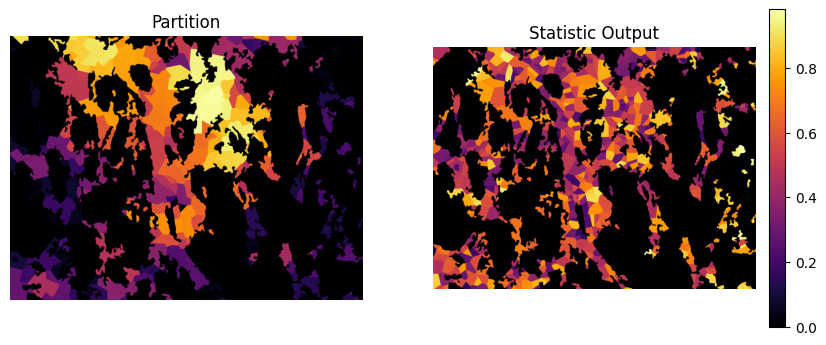

In [3]:
# Base path for the images directory
images_path = Path('images')

# Construct full paths for fibres image and mask
image_path = images_path / "fibres.tiff"
mask_path = images_path / "noise_mask.png"

# Read images
image = tiff.imread(image_path)
mask = plt.imread(mask_path)[:, :, 0]


# Create an instance of FibreDescriptor with the image data
fd = fibsight.FibreDescriptor(image, verbose=1)
fd.summary.noise_mask = mask

# Enhance image using Gabor filters
kernel_params = {"size": (51, 51), "gamma": 1, "psi": 0}
lambdas = 2 * np.array([41, 17, 35, 31])
fd.enhance(lambdas, kernel_params, method="lr")

# Generate a graph representation of the image
fd.make_graph()  # Graph is a nx object stored in fd.summary.skl_graph

# Compute (weighted) alignment score using Gabor's optimal angles in each of the cells of the partition
fd.compute_score_partition(
    x=fd.angles,
    statistic="align_score",
    mask=None,
    weights=fd.enhanced ** 1.5,
)


# Visualise results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(fd.summary.partition * mask, cmap="inferno")
axs[0].set_title("Partition")
axs[0].axis("off")

im = axs[1].imshow(fd.local_description * mask, cmap="inferno")
axs[1].set_title("Statistic Output")
axs[1].axis("off")

fig.colorbar(im, ax=axs[1], orientation='vertical', fraction=0.045, pad=0.04)

plt.show()

## Custom Classes

The main aim of the `GraphConfig` class is to provide a structured way to configure various parameters that control how images are processed and converted into graphs. This class acts as a container for all these settings. An instance of this class with the desired settings can be created and then passed to an instance of the `FibreDescriptor` class.


In [4]:
help(GraphConfig)

Help on class GraphConfig in module fibsight.custom.config_template:

class GraphConfig(builtins.object)
 |  GraphConfig(binary_method: str = 'otsu', method_callable: Optional[Callable] = None, skeleton_method: str = 'parallel_thinning', prune: bool = True, min_length: int = 20, max_iter: int = 5, partition_method: str = 'voronoi') -> None
 |  
 |  Configuration class for graph processing methods in image analysis.
 |  
 |  Parameters
 |  ----------
 |  binary_method : Optional[str]
 |      The name of the thresholding method used to binarize the image.
 |      Default is "otsu".
 |  method_callable : Optional[Callable]
 |      A custom callable function for thresholding. If provided,
 |      it takes precedence over `binary_method`.
 |  skeleton_method : str
 |      The method used for skeletonisation of binary images.
 |      Default is "parallel_thinning".
 |  prune : bool
 |      Whether to prune small branches during skeletonisation. Default is True.
 |  min_length : int
 |      T

### Custom Thresholding Method

In FibreSight, the default thresholding method of the enhanced image is [Otsu's method](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.threshold_otsu). However, you can also define and use a custom thresholding method using a callable class.


2025-06-05 20:23:39,488 - fibsight.pipeline.characterise - INFO - Calling method: enhance
2025-06-05 20:23:45,085 - fibsight.pipeline.characterise - INFO - Method enhance completed
2025-06-05 20:23:45,085 - fibsight.pipeline.characterise - INFO - Calling method: make_graph
2025-06-05 20:23:45,090 - fibsight.graphs.process - INFO - Registered new thresholding method: 'CustomThresholding'
2025-06-05 20:23:45,093 - fibsight.graphs.process - INFO - Binary image created using the 'CustomThresholding' method.
2025-06-05 20:24:57,975 - fibsight.pipeline.characterise - INFO - Method make_graph completed


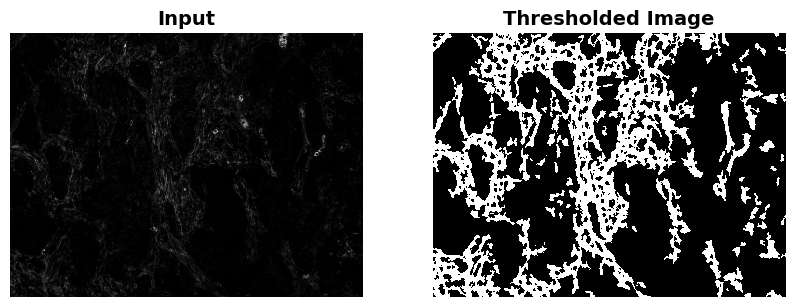

In [5]:
# Define a custom thresholding method
class CustomThresholding(ThresholdingMethod):
    def __call__(self, image):
        threshold = np.mean(image)
        return image > threshold

# Create a GraphConfig object with the custom thresholding method
config = GraphConfig(method_callable=CustomThresholding)

# Load the image and the mask
image = tiff.imread(image_path)#[:1000, :1000]
mask = plt.imread(mask_path)[:, :, 0]#[:1000, :1000]

# Create a FibreDescriptor object with the loaded image
fd = fibsight.FibreDescriptor(image, config=config, verbose=1)
fd.summary.noise_mask = mask

# Define Gabor parameters to optimise over
kernel_params = {"size": (51, 51), "gamma": 1, "psi": 0}
lambdas = 2 * np.array([41, 17, 35, 31])

# Enhance image using Gabor filters
fd.enhance(lambdas, kernel_params, method="lr")

# Create graph
fd.make_graph()


# Visualise the partition and the computed statistic
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(fd.image, cmap="gray", interpolation="none")
axs[0].set_title("Input", fontsize=14, fontweight="bold")
axs[0].axis("off")

axs[1].imshow(fd.summary.binary, cmap="gray", interpolation="none")
axs[1].set_title("Thresholded Image", fontsize=14, fontweight="bold")
axs[1].axis("off")

plt.show()

### Custom Partition Method

In FibreSight, the default partitioning method is based on triangulation using the Voronoi diagram. This method leverages the nodes of the graph as generators to create partitions. However, you can also define and use custom partition methods by creating a callable class.

To create a custom partition:

1. Define a Custom Partition Class
   - The class should be callable, i.e. it should implement the \_\_call\_\_ method.
   - The call method should take an instance of `ImageToGraph` as an argument and update it with the partition result.
2. Register the Custom Partition Method:
   - Use the `register_partition_method` method of the `ImageToGraph` class to register your custom partition method.
3. Apply the Custom Partition Method
   - Overwrite the argument `partition_method` of `GraphConfig` using the name of the custom method.


Registered partition methods({'my_custom_partition': <__main__.MyCustomPartition object at 0x74b500e5f7f0>})


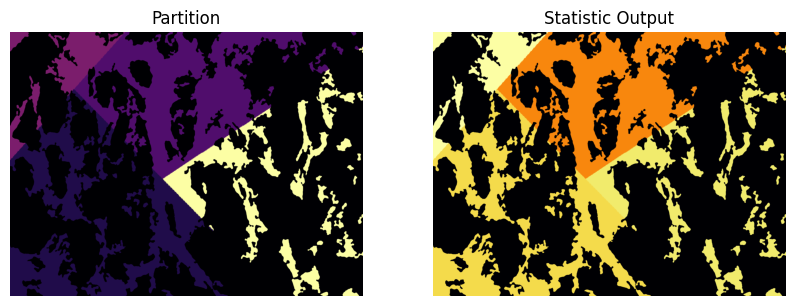

In [6]:
# Step 1: Custom Partition Class
class MyCustomPartition:
    """
    Custom partition method using a predefined partition image.
    """

    def __call__(self, image_to_graph_instance):
        partition = self.perform_partition(image_to_graph_instance.image)
        image_to_graph_instance.partition = partition

    def perform_partition(self, image: np.ndarray):
        return tiff.imread(os.path.join("images", "partition.tiff"))


# Step 2: Instantiate FibreDescriptor and register the custom partition method
fd = fibsight.FibreDescriptor(image)
fd.register_partition_method("my_custom_partition", MyCustomPartition())

# Verify that the method is registered
print(f"Registered partition methods({fd.summary.partition_methods})")

# Configure GraphConfig accordingly
config = GraphConfig(
    skeleton_method="zhang",
    partition_method="my_custom_partition"
)

# Update config
fd.config = config

# Same as before
kernel_params = {"size": (51, 51), "gamma": 1, "psi": 0}
lambdas = 2 * np.array([41, 17, 35, 31])

fd.summary.noise_mask = mask
fd.enhance(lambdas, kernel_params, method="lr")
fd.make_graph()
fd.compute_score_partition(
    x=fd.angles,
    statistic="align_score",
    mask=None,
    weights=fd.enhanced ** 1.5
)

# Visualise the partition and the computed statistic
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(fd.summary.partition * mask, cmap="inferno")
axs[0].set_title("Partition")
axs[0].axis("off")

axs[1].imshow(fd.local_description * mask, cmap="inferno")
axs[1].set_title("Statistic Output")
axs[1].axis("off")

plt.show()

### Custom Skeletonisation Method


In [7]:
# TODO

### Custom Statistics


In [8]:
# TODO

## Regularisation


In [9]:
# TODO